In [106]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [107]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [108]:
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [109]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B2  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


In [110]:
trainpath = r'C:/Users/praro/Downloads/E-Waste classification dataset/modified-dataset/train' # <-- Make sure this path is correct
testpath= r'C:/Users/praro/Downloads/E-Waste classification dataset/modified-dataset/test'
validpath = r'C:/Users/praro/Downloads/E-Waste classification dataset/modified-dataset/val'


In [111]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [112]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [113]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [114]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [129]:
AUTOTUNE = tf.data.AUTOTUNE

datatrain = datatrain.map(lambda x, y: (preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
datavalid = datavalid.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
datatest = datatest.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
#


In [130]:
image_size = (128, 128)  # Define the input image size
num_classes = len(class_names)  # Number of classes in the dataset
base_model = EfficientNetV2B2(input_shape= image_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


In [131]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

callbacks = [early_stop, reduce_lr]


In [132]:
history = model.fit(datatrain,
                    validation_data=datavalid,
                    epochs=15,
                    callbacks=callbacks)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 482ms/step - accuracy: 0.5530 - loss: 1.5614 - val_accuracy: 0.9333 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 406ms/step - accuracy: 0.9136 - loss: 0.4006 - val_accuracy: 0.9533 - val_loss: 0.2413 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9330 - loss: 0.2697 - val_accuracy: 0.9533 - val_loss: 0.1946 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 358ms/step - accuracy: 0.9451 - loss: 0.2165 - val_accuracy: 0.9533 - val_loss: 0.1765 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.9552 - loss: 0.1850 - val_accuracy: 0.9600 - val_loss: 0.1608 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.9572 - loss: 0.1630 - val_accuracy: 0.9567 - val_loss: 0.1541 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 396ms/step - accuracy: 0.9561 - loss: 0.

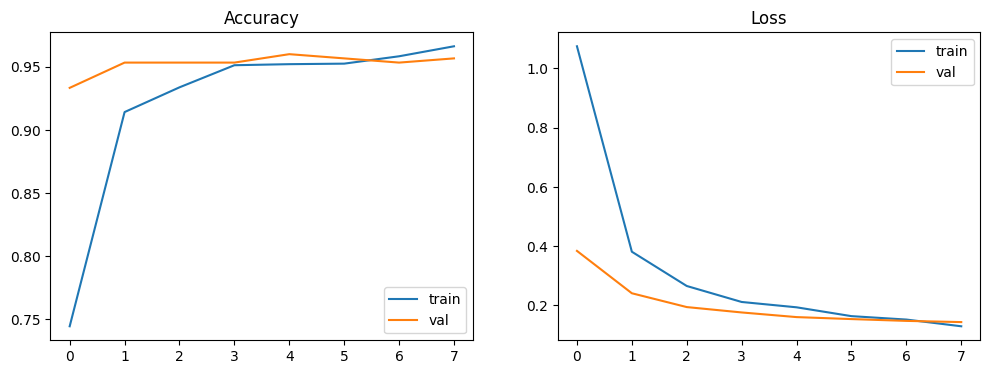

In [134]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.show()


In [136]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # unfreeze top 30 layers only
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_finetune = model.fit(datatrain,
                              validation_data=datavalid,
                              epochs=15,
                              callbacks=callbacks)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 590ms/step - accuracy: 0.9468 - loss: 0.2482 - val_accuracy: 0.9533 - val_loss: 0.2112 - learning_rate: 1.0000e-05
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 586ms/step - accuracy: 0.9475 - loss: 0.2234 - val_accuracy: 0.9400 - val_loss: 0.2048 - learning_rate: 1.0000e-05
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.9463 - loss: 0.2261 - val_accuracy: 0.9600 - val_loss: 0.1978 - learning_rate: 1.0000e-05
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9567 - loss: 0.1947 - val_accuracy: 0.9567 - val_loss: 0.1954 - learning_rate: 1.0000e-05
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 451ms/step - accuracy: 0.9416 - loss: 0.2181 - val_accuracy: 0.9533 - val_loss: 0.1842 - learning_rate: 1.0000e-05
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9557 - loss: 0.1908 - val_accuracy: 0.9500 - val_loss: 0.1870 - learning_rate: 1.0000e-05


In [138]:
test_loss, test_acc = model.evaluate(datatest)
print(f"Test Accuracy: {test_acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.9047 - loss: 0.2711
Test Accuracy: 0.9200


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step
                 precision    recall  f1-score   support

        Battery       0.86      0.80      0.83        30
       Keyboard       0.97      0.97      0.97        30
      Microwave       0.97      0.93      0.95        30
         Mobile       1.00      0.97      0.98        30
          Mouse       1.00      0.97      0.98        30
            PCB       0.90      0.93      0.92        30
         Player       0.85      0.97      0.91        30
        Printer       0.91      0.97      0.94        30
     Television       0.97      0.93      0.95        30
Washing Machine       0.93      0.90      0.92        30

       accuracy                           0.93       300
      macro avg       0.93      0.93      0.93       300
   weighted avg       0.93      0.93      0.93       300



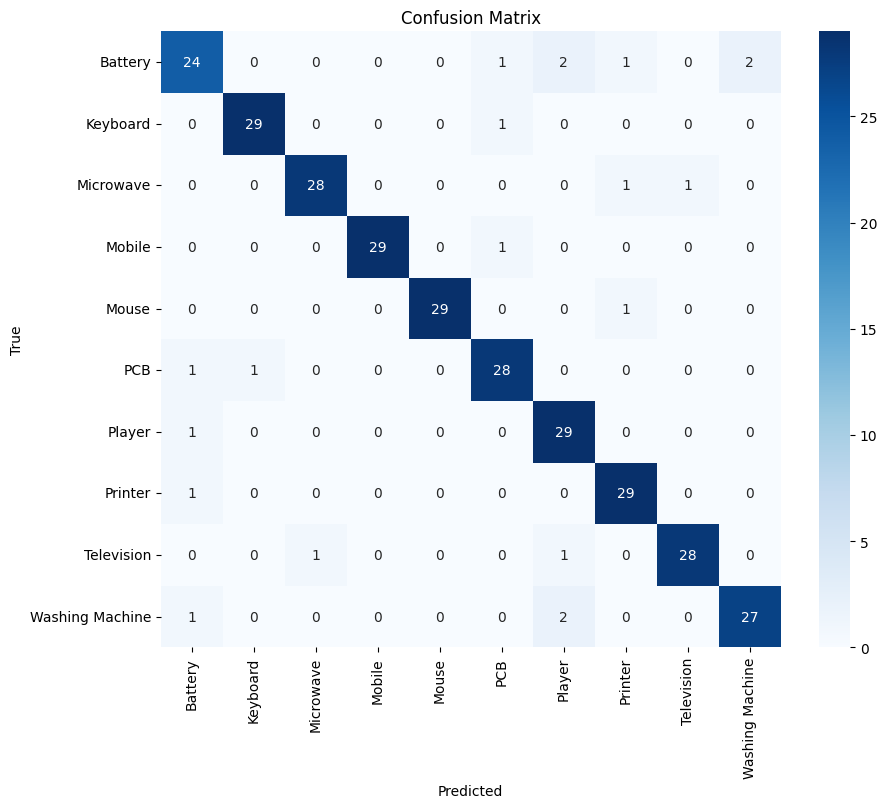

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(datatest)
y_pred_labels = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in datatest], axis=0)

print(classification_report(y_true, y_pred_labels, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [140]:
model.save('Efficient_classify_prakritiroy.keras')